# Data Parsing and Feature Engineering

In this notebook the raw data will be parsed to extract all possible information and encode columns into useful machine learning appropiate values. There will also be engineering of additional columns to better build on the data already presented.

Finally the train/test split of the data will be applied in preparation for the modeling analysis.

In [182]:
# data science
import numpy as np
import pandas as pd

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
import seaborn as sns
sns.set_palette("deep")
sns.set_context("notebook")

# For parsing sunrise and sunset
from astral import LocationInfo
import datetime
from astral.sun import sun
SEOUL_CITY = LocationInfo("Seoul", "Republic of Korea", "Asia/Seoul", 37.5665, 126.9780)

### Data Inspection and Parsing

This dataset is very clean and provides 8760 entries with zero null values in any column.

In [163]:
# custom column names to shorten and remove obscure symbols
colnames=['date', 'bike_rentals', 'hour', 'temperature', "humidity", 'windspeed', 'visibility', 'dew_point', 'solar_radiation', 'rainfall', 'snowfall', 'season', 'is_holiday', 'is_functioning'] 
raw_df = pd.read_csv("SeoulBikeData.csv", header=0, names=colnames,encoding='cp1252')
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   date             8760 non-null   object 
 1   bike_rentals     8760 non-null   int64  
 2   hour             8760 non-null   int64  
 3   temperature      8760 non-null   float64
 4   humidity         8760 non-null   int64  
 5   windspeed        8760 non-null   float64
 6   visibility       8760 non-null   int64  
 7   dew_point        8760 non-null   float64
 8   solar_radiation  8760 non-null   float64
 9   rainfall         8760 non-null   float64
 10  snowfall         8760 non-null   float64
 11  season           8760 non-null   object 
 12  is_holiday       8760 non-null   object 
 13  is_functioning   8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.2+ KB


First important note is that the is_functioning boolean is only True for hours where bikes are rentable. It doesn't make sense to study these hours as inherently there are no bike rental operations, so they will be excluded for both training and testing. Shown is a plot of all hours with rentals less than 100, separated by whether the hour was functional.

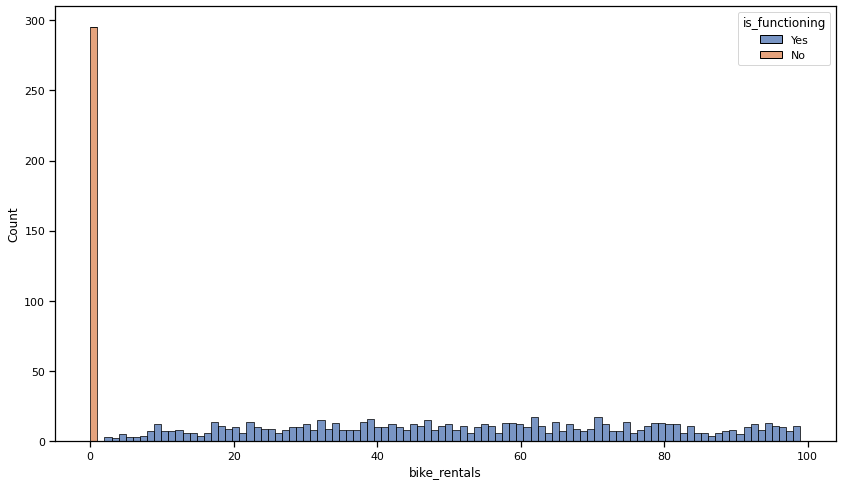

In [164]:
sns.histplot(data=raw_df[raw_df["bike_rentals"] < 100], x="bike_rentals", hue="is_functioning", multiple="stack", bins=100)
analysis_df = raw_df[raw_df["is_functioning"] == 'Yes'].drop(columns=["is_functioning"])

Next we apply simple encodings to the string columns
- change date to a datetime type
- change is_holiday to boolean
- one hot encode season

In [165]:
# encode date as datetime
analysis_df['date'] =  pd.to_datetime(analysis_df['date'], format='%d/%m/%Y')

# encode is_holiday as boolean
analysis_df['is_holiday'] = analysis_df['is_holiday'].map({"Holiday": True, "No Holiday": False})

# encode season ass
seasons_df = pd.get_dummies(analysis_df['season'], prefix='season')
analysis_df = analysis_df.join(seasons_df)
analysis_df = analysis_df.drop(columns=['season'])

Now we introduce some additional numerical time columns for month and day of week, as well as a boolean for separating weekday and weekend

In [172]:
# day of week and month
analysis_df["dayofyear"] = analysis_df["date"].dt.dayofyear
analysis_df["dayofweek"] = analysis_df["date"].dt.dayofweek
analysis_df["month"] = analysis_df["date"].dt.month
# day of week is 0-4 Mon-Fri, 5,6 is Sat,Sun
analysis_df["is_weekday"] = analysis_df["date"].dt.dayofweek < 5

### Sunset Sunrise Deltas

Calculate how far away from the days sunrise or sunset the given hour is. Generally expected to be very correlated to solar_radiation however that does not account for cloudcover.

In [173]:
def timesince_sunrise(input_date, input_hour):
    sun_dict = sun(SEOUL_CITY.observer, date=input_date, tzinfo=SEOUL_CITY.timezone)
    hour_midpoint_datetime = input_date + datetime.timedelta(hours=input_hour) + datetime.timedelta(minutes=30)
    time_delta = input_hour - sun_dict['sunrise'].hour
    return time_delta

def timesince_sunset(input_date, input_hour):
    sun_dict = sun(SEOUL_CITY.observer, date=input_date, tzinfo=SEOUL_CITY.timezone)
    hour_midpoint_datetime = input_date + datetime.timedelta(hours=input_hour) + datetime.timedelta(minutes=30)
    time_delta = input_hour - sun_dict['sunset'].hour
    return time_delta

In [174]:
analysis_df["sunrise_delta"] = analysis_df.apply(lambda x: timesince_sunrise(x['date'], x['hour']), axis=1)
analysis_df["sunset_delta"] = analysis_df.apply(lambda x: timesince_sunset(x['date'], x['hour']), axis=1)

### Rush Hour

Let's define a variable that covers the general work rushour period. Using this source: 
- https://theculturetrip.com/asia/south-korea/articles/a-guide-to-using-the-subway-in-seoul/

We take this to be 6AM-9AM, 4PM-7PM Mon-Fri on all weekdays that are not part of a holiday

In [179]:
# This is a rather complex expression by
analysis_df["is_rushhour"] = analysis_df["is_weekday"] & ~analysis_df["is_holiday"] & (((analysis_df["hour"] > 5) & (analysis_df["hour"] < 10)) | ((analysis_df["hour"] > 15) & (analysis_df["hour"] < 20)))

### Cyclical Encoding

When keeping periodic variables like hours and days it is important to remember that hour 23 and hour 0 are very similar conditions, despite having a very different value. Because of this it is often useful to capture the periodic nature by a circular encoding, by extracting the sin and cosine using the periodic quantity as a phase. Here I follow the guidelines from this kaggle writeup:

- https://www.kaggle.com/avanwyk/encoding-cyclical-features-for-deep-learning

In [184]:
def cyclical_encode(data, col, max_val):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max_val)
    return data

cyclical_encode(analysis_df, "dayofyear", 365)
cyclical_encode(analysis_df, "dayofweek", 7)
cyclical_encode(analysis_df, "month", 12)
cyclical_encode(analysis_df, "hour", 24)

,date,bike_rentals,hour,temperature,humidity,windspeed,visibility,dew_point,solar_radiation,rainfall,...,is_rushhour,dayofyear,dayofyear_sin,dayofyear_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos,hour_sin,hour_cos
0,2017-12-01,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,...,False,335,-0.493776,0.869589,-0.433884,-0.900969,-2.449294e-16,1.000000,0.000000,1.000000
1,2017-12-01,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,...,False,335,-0.493776,0.869589,-0.433884,-0.900969,-2.449294e-16,1.000000,0.258819,0.965926
2,2017-12-01,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,...,False,335,-0.493776,0.869589,-0.433884,-0.900969,-2.449294e-16,1.000000,0.500000,0.866025
3,2017-12-01,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,...,False,335,-0.493776,0.869589,-0.433884,-0.900969,-2.449294e-16,1.000000,0.707107,0.707107
4,2017-12-01,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,...,False,335,-0.493776,0.869589,-0.433884,-0.900969,-2.449294e-16,1.000000,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2018-11-30,1003,19,4.2,34,2.6,1894,-10.3,0.0,0.0,...,True,334,-0.508671,0.860961,-0.433884,-0.900969,-5.000000e-01,0.866025,-0.965926,0.258819
8756,2018-11-30,764,20,3.4,37,2.3,2000,-9.9,0.0,0.0,...,False,334,-0.508671,0.860961,-0.433884,-0.900969,-5.000000e-01,0.866025,-0.866025,0.500000
8757,2018-11-30,694,21,2.6,39,0.3,1968,-9.9,0.0,0.0,...,False,334,-0.508671,0.860961,-0.433884,-0.900969,-5.000000e-01,0.866025,-0.707107,0.707107
8758,2018-11-30,712,22,2.1,41,1.0,1859,-9.8,0.0,0.0,...,False,334,-0.508671,0.860961,-0.433884,-0.900969,-5.000000e-01,0.866025,-0.500000,0.866025
